In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

In [3]:
# import jax

# jax.config.update("jax_compilation_cache_dir", "../jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

# from desc import set_device
# set_device("gpu")

In [4]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [5]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import *
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import *
from desc.vmec_utils import *
from desc.input_reader import *
from desc.continuation import *

print_backend_info()

DESC version=0.14.2+264.g070d56a27.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: CPU, with 8.13 GB available memory.


In [6]:
from desc.optimize.utils import compute_jac_scale
eq = get("precise_QA")
eq.dim_x

1462

In [79]:
from desc.optimize.utils import compute_jac_scale

method = "direct1"
tconds = []
jconds = []
jscaleconds = []
jtconds = []
jtsconds = []
ress = np.arange(8, 17)
for res in ress:
    eq.change_resolution(L=res, M=res, N=res, L_grid=2*res, M_grid=2*res, N_grid=2*res)
    grid = ConcentricGrid(L=eq.L_grid, M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, sym=eq.sym)
    transform = Transform(grid=grid, basis=eq.R_basis, method=method)
    if method in ["direct2"]:
        A = transform.matrices[method][0]
    elif method in ["fft"]:
        A = transform.matrices[method][0][0]
    else:
        A = transform.matrices[method][0][0][0]
    tcond = jnp.linalg.cond(A)
    tconds.append(tcond)
    P = jnp.concatenate([A, A], axis=0)
    Pinv = jnp.linalg.pinv(P)
    print(f"LMN={res:^4} {'F-Z transform':^30}  ===>  {tcond:.2e}")
    obj = ObjectiveFunction(ForceBalance(eq), jac_chunk_size=1)
    cons = get_fixed_boundary_constraints(eq)
    cons = maybe_add_self_consistency(eq, cons)
    con = ObjectiveFunction(cons)
    obj = LinearConstraintProjection(obj, con)
    obj.build(verbose=0)
    J = obj.jac_scaled_error(obj.x())
    scale, scale_inv = compute_jac_scale(J)
    Jcond = jnp.linalg.cond(J)
    Jscalecond = jnp.linalg.cond(J*scale)
    JTcond = jnp.linalg.cond(Pinv@J)
    scale2, _ = compute_jac_scale(Pinv@J)
    JTScond = jnp.linalg.cond(scale2*(Pinv@J))
    jtconds.append(JTcond)
    jtsconds.append(JTScond)
    jconds.append(Jcond)
    jscaleconds.append(Jscalecond)
    print(f"LMN={res:^4} {'Jacobian':^30}  ===>  {Jcond:.2e}")
    print(f"LMN={res:^4} {'Preconditioned Jacobian':^30}  ===>  {Jscalecond:.2e}")
    print(f"LMN={res:^4} {'Preconditioned Jacobian 2':^30}  ===>  {JTcond:.2e}")
    print(f"LMN={res:^4} {'Preconditioned Jacobian 3':^30}  ===>  {JTScond:.2e}")
    del J, A

LMN= 8           F-Z transform           ===>  7.10e+00
LMN= 8              Jacobian             ===>  3.87e+07
LMN= 8      Preconditioned Jacobian      ===>  5.27e+06
LMN= 8     Preconditioned Jacobian 2     ===>  7.84e+03
LMN= 8     Preconditioned Jacobian 3     ===>  6.92e+02
LMN= 9           F-Z transform           ===>  7.53e+00
LMN= 9              Jacobian             ===>  2.55e+08
LMN= 9      Preconditioned Jacobian      ===>  4.10e+07
LMN= 9     Preconditioned Jacobian 2     ===>  5.07e+03
LMN= 9     Preconditioned Jacobian 3     ===>  9.67e+02
LMN= 10          F-Z transform           ===>  7.99e+00
LMN= 10             Jacobian             ===>  2.18e+09
LMN= 10     Preconditioned Jacobian      ===>  2.57e+08
LMN= 10    Preconditioned Jacobian 2     ===>  1.19e+04
LMN= 10    Preconditioned Jacobian 3     ===>  1.10e+03
LMN= 11          F-Z transform           ===>  8.46e+00
LMN= 11             Jacobian             ===>  6.26e+09
LMN= 11     Preconditioned Jacobian      ===>  7

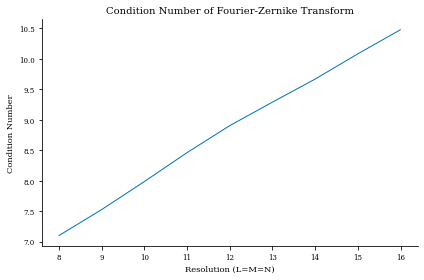

In [80]:
plt.plot(ress, tconds)
plt.xlabel("Resolution (L=M=N)")
plt.ylabel("Condition Number")
plt.title("Condition Number of Fourier-Zernike Transform")
plt.savefig("fz-transform-condition-number.png", dpi=400)

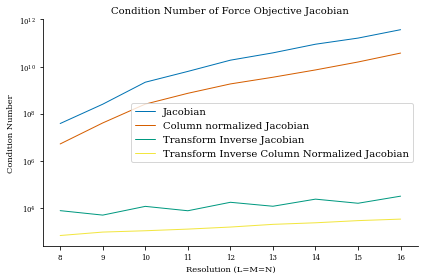

In [81]:
plt.semilogy(ress, jconds, label="Jacobian")
plt.semilogy(ress, jscaleconds, label="Column normalized Jacobian")
plt.semilogy(ress, jtconds, label="Transform Inverse Jacobian")
plt.semilogy(ress, jtsconds, label="Transform Inverse Column Normalized Jacobian")
plt.legend()
plt.xlabel("Resolution (L=M=N)")
plt.ylabel("Condition Number")
plt.title("Condition Number of Force Objective Jacobian")
plt.savefig("jacobian-condition-number.png", dpi=400)

In [44]:
# eq = get("precise_QA")
res = 10
eq = Equilibrium(L=res, M=res, N=4)
method = "direct1"
grid = ConcentricGrid(L=eq.L_grid, M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, sym=eq.sym)
transformR = Transform(grid=grid, basis=eq.R_basis, method=method)
transformZ = Transform(grid=grid, basis=eq.Z_basis, method=method)
transformL = Transform(grid=grid, basis=eq.L_basis, method=method)
A = transformR.matrices[method][0][0][0]
B = transformZ.matrices[method][0][0][0]
C = transformL.matrices[method][0][0][0]
obj = ObjectiveFunction(ForceBalance(eq), jac_chunk_size=1)
cons = get_fixed_boundary_constraints(eq)
cons = maybe_add_self_consistency(eq, cons)
con = ObjectiveFunction(cons)
obj = LinearConstraintProjection(obj, con)
obj.build(verbose=0)
J = obj.jac_scaled_error(obj.x())

In [45]:
# P = jnp.concatenate([A, B], axis=1)
# P = jnp.concatenate([A, A], axis=0)
# P = jnp.concatenate([A, jnp.zeros_like(A)], axis=0)
m,n = A.shape
m1,n1 = B.shape
# P = jnp.block([[A, jnp.zeros((m, m))], [jnp.zeros((m, n)), jnp.eye(m)]])
P = jnp.block([[A, jnp.zeros((m, n1))], [jnp.zeros((m1, n)), B]])

In [46]:
jnp.linalg.matrix_rank(P)

Array(1188, dtype=int64)

In [47]:
P.shape, J.shape

((7854, 1188), (7854, 1398))

In [48]:
from desc.optimize.utils import compute_jac_scale

# Pinv = jnp.linalg.pinv(P)
Pinv = P.T
cond1 = jnp.linalg.cond(Pinv)
cond2 = jnp.linalg.cond(Pinv@J)
cond3 = jnp.linalg.cond(J)
scale1, _ = compute_jac_scale(Pinv@J)
scale2, _ = compute_jac_scale(J)
cond4 = jnp.linalg.cond(scale1*(Pinv@J))
cond5 = jnp.linalg.cond(scale2*J)
print(f"Pinv       : {cond1:.2e}")
print(f"J          : {cond3:.2e}")
print(f"d*J        : {cond5:.2e}")
print(f"Pinv@J     : {cond2:.2e}")
print(f"d*(Pinv@J) : {cond4:.2e}")

Pinv       : 8.02e+00
J          : 9.84e+15
d*J        : 6.33e+15
Pinv@J     : 1.84e+06
d*(Pinv@J) : 9.04e+05


In [49]:
from desc.optimize.utils import chol, solve_triangular_regularized

J_h = J*scale2
f = obj.compute_scaled_error(obj.x())
U, s, Vt = jnp.linalg.svd(J_h, full_matrices=False)
p_newton = Vt.T @ (1/s * (U.T @ f))
step_svd = scale2*p_newton

Q1, R1 = qr(J_h, mode="economic")
step_qr = scale2*solve_triangular_regularized(R1, Q1.T @ f)

In [50]:
from desc.optimize.utils import chol, solve_triangular_regularized

J_h = Pinv@J
f = obj.compute_scaled_error(obj.x())
U, s, Vt = jnp.linalg.svd(J_h, full_matrices=False)
step_psvd = Vt.T @ (1/s * (U.T @ (Pinv@f)))

Q, R = qr(J_h.T, mode="economic")
step_pqr = Q @ solve_triangular_regularized(R.T, (Pinv@f), lower=True)

R = chol(J_h.T@J_h)
step_pcho = cho_solve((R, True), J_h.T@(Pinv@f))

In [51]:
from desc.optimize.utils import chol
J_h = J*scale2
f = obj.compute_scaled_error(obj.x())
R = chol(J_h.T@J_h)
p_newton = cho_solve((R, True), J_h.T@f)
step_cho = scale2*p_newton

In [52]:
max(J@step_svd-f), max(J@step_psvd-f), max(J@step_pcho-f), max(J@step_pqr-f), max(J@step_cho-f)

(Array(0., dtype=float64),
 Array(0., dtype=float64),
 Array(0., dtype=float64),
 Array(0., dtype=float64),
 Array(0., dtype=float64))

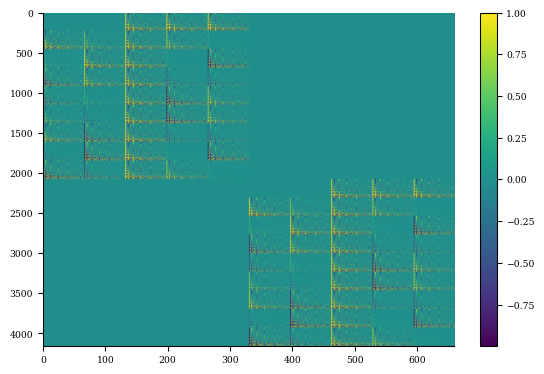

In [16]:
plt.imshow(P, aspect="auto")
plt.colorbar()

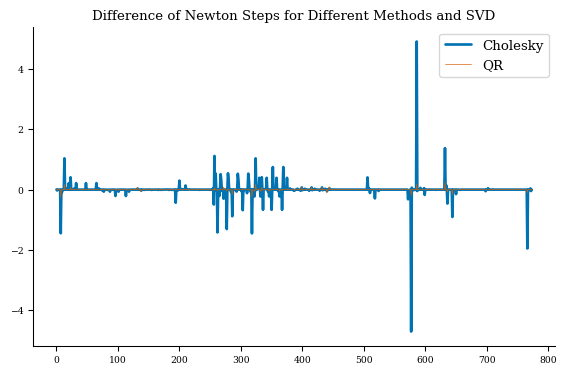

In [17]:
# plt.plot(step_svd-step_psvd, label="SVD Precondition", lw=4)
plt.plot(step_svd-step_cho, label="Cholesky", lw=2)
# plt.plot(step_svd-step_pcho, label="Cholesky Preconditioned", lw=1)
# plt.plot(step_svd-step_pqr, label="QR Preconditioned", lw=1)
plt.plot(step_svd-step_qr, label="QR", lw=0.5)
plt.legend()
# plt.savefig("transform-steps-diff-methods.png", dpi=400)
plt.title("Difference of Newton Steps for Different Methods and SVD")
plt.savefig("transform-steps-qr-cho-svd.png", dpi=400)

In [18]:
max(step_svd-step_qr), max(step_svd-step_cho), max(step_svd-step_psvd), max(step_svd-step_pqr), max(step_svd-step_pcho), max(step_psvd-step_pcho), max(step_psvd-step_pqr)

(Array(0.2384, dtype=float64),
 Array(4.9142, dtype=float64),
 Array(4.9107, dtype=float64),
 Array(4.9107, dtype=float64),
 Array(4.9107, dtype=float64),
 Array(0.0006, dtype=float64),
 Array(0., dtype=float64))

In [19]:
max(step_svd-scale2*step_cho)

Array(4.9141, dtype=float64)

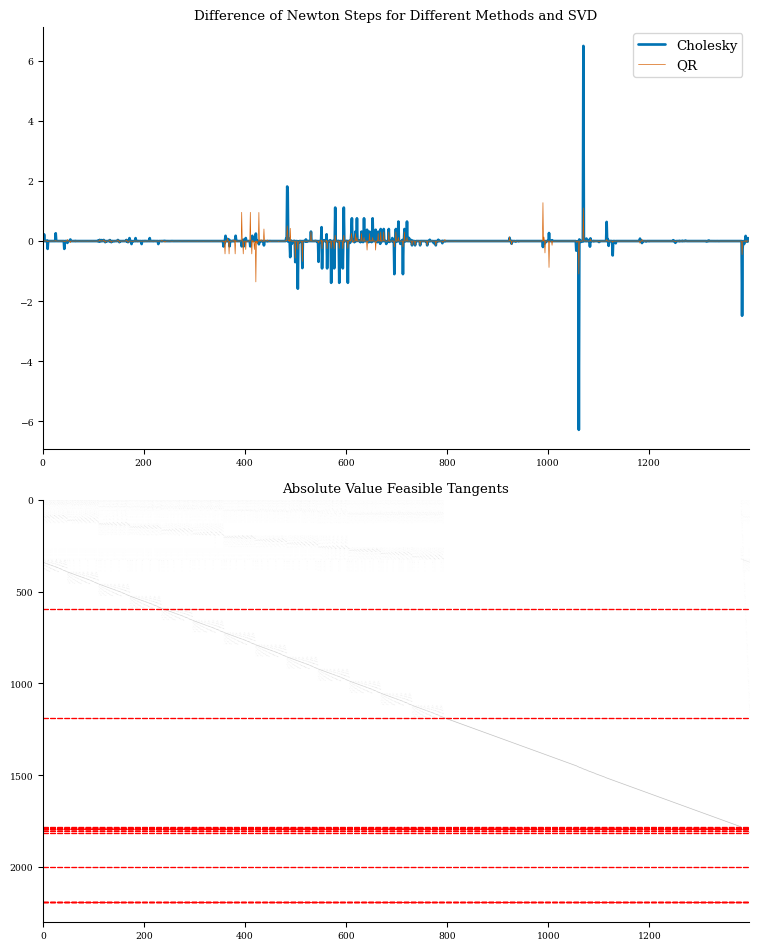

In [53]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=False)
axs[0].plot(step_svd-step_cho, label="Cholesky", lw=2)
axs[0].plot(step_svd-step_qr, label="QR", lw=0.5)
axs[0].set_xlim(0, obj._feasible_tangents.shape[1])

axs[0].legend()
axs[0].set_title("Difference of Newton Steps for Different Methods and SVD")

im = axs[1].imshow(jnp.abs(obj._feasible_tangents), aspect="auto", cmap="binary")
axs[1].set_title("Absolute Value Feasible Tangents")

size_total = 0
for key, value in eq.params_dict.items():
    size = value.size
    size_total += size
    axs[1].axhline(y=size_total, color='r', linestyle='--')

plt.tight_layout()
plt.savefig("transform-objective-Z-res10104.png", dpi=1000)

In [12]:
start = len(eq.x_idx["R_lmn"]) + len(eq.x_idx["Z_lmn"]) - len(eq.x_idx["Rb_lmn"]) - len(eq.x_idx["Zb_lmn"])
end = start + len(eq.x_idx["L_lmn"])
L_idx = jnp.arange(start, end)
J_without_L = jnp.delete(J, L_idx, axis=1)
J_just_L = J[:, L_idx]
J_without_L.shape, J_just_L.shape, J.shape

((4114, 405), (4114, 294), (4114, 699))

In [13]:
scale1, _ = compute_jac_scale(J_without_L)
cond1 = jnp.linalg.cond(scale1*J_without_L)
cond2 = jnp.linalg.cond(J)
cond3 = jnp.linalg.cond(J_just_L)
print(f"J_without_L       : {cond1:.2e}")
print(f"J                 : {cond2:.2e}")
print(f"J_just_L          : {cond3:.2e}")

J_without_L       : 1.53e+05
J                 : 8.31e+15
J_just_L          : 6.60e+04


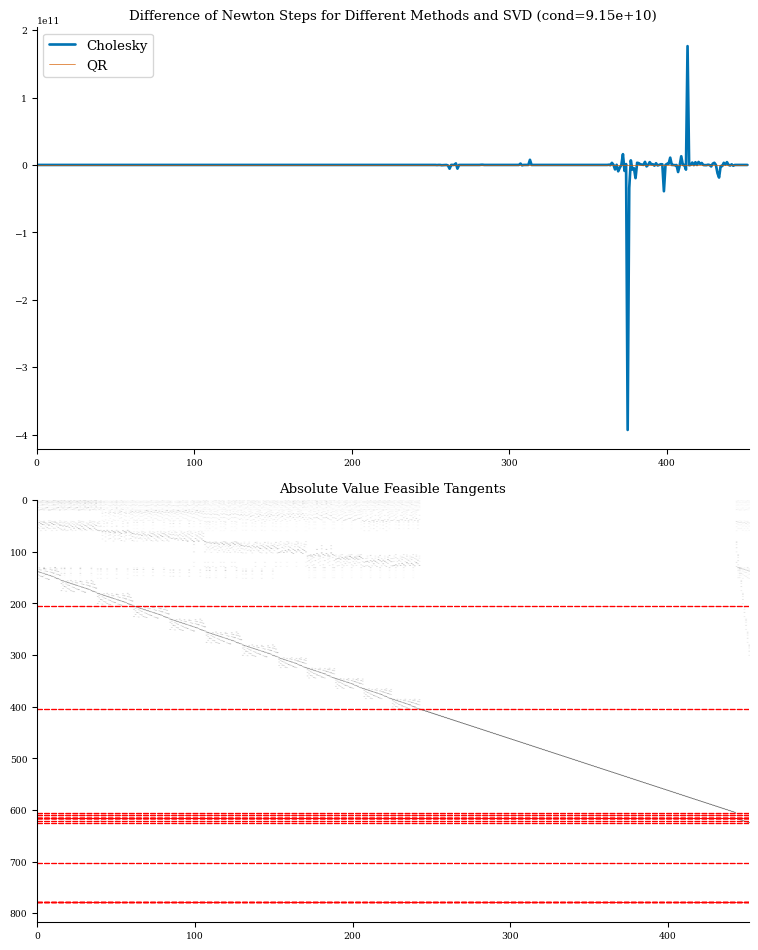

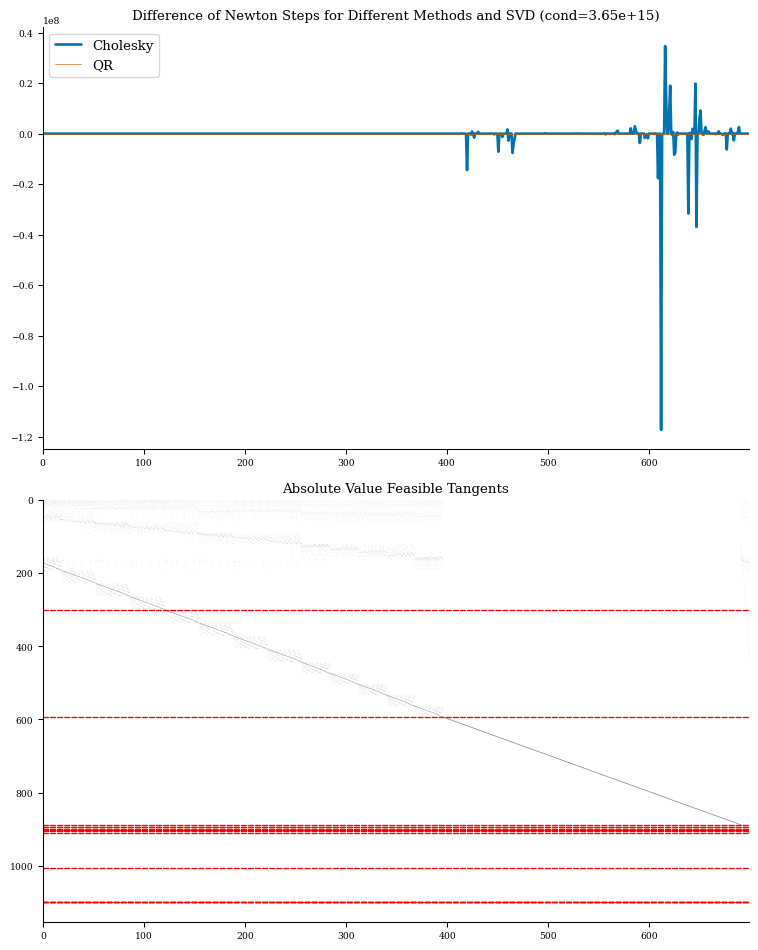

In [78]:
from desc.optimize.utils import chol, solve_triangular_regularized, compute_jac_scale 
# eq = get("precise_QA")

for res in [8, 10]:
    eq = Equilibrium(L=res, M=res, N=4, sym=True, spectral_indexing="ansi")
    grid = QuadratureGrid(L=eq.L_grid, M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP)
    obj = ObjectiveFunction(ForceBalance(eq, grid=grid))
    cons = get_fixed_boundary_constraints(eq)
    cons = maybe_add_self_consistency(eq, cons)
    con = ObjectiveFunction(cons)
    obj = LinearConstraintProjection(obj, con)
    obj.build(verbose=0)
    J = obj.jac_scaled_error(obj.x())
    f = obj.compute_scaled_error(obj.x())
    scale2, _ = compute_jac_scale(J)

    J_h = J*scale2
    U, s, Vt = jnp.linalg.svd(J_h, full_matrices=False)
    step_svd = scale2*(Vt.T @ (1/s * (U.T @ f)))
    del U, s, Vt

    Q1, R1 = qr(J_h, mode="economic")
    step_qr = scale2*solve_triangular_regularized(R1, Q1.T @ f)
    del Q1, R1

    R = chol(J_h.T@J_h)
    step_cho = scale2*cho_solve((R, True), J_h.T@f)
    del R

    fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=False)
    axs[0].plot((step_svd-step_cho)/step_svd, label="Cholesky", lw=2)
    axs[0].plot((step_svd-step_qr/step_svd), label="QR", lw=0.5)
    axs[0].set_xlim(0, obj._feasible_tangents.shape[1])

    axs[0].legend()
    axs[0].set_title(f"Difference of Newton Steps for Different Methods and SVD (cond={jnp.linalg.cond(scale2*J):.2e})")

    im = axs[1].imshow(jnp.abs(obj._feasible_tangents), aspect="auto", cmap="binary")
    axs[1].set_title("Absolute Value Feasible Tangents")

    size_total = 0
    for key, value in eq.params_dict.items():
        size = value.size
        size_total += size
        axs[1].axhline(y=size_total, color='r', linestyle='--')

    plt.tight_layout()
    plt.savefig(f"xdiffrel-Z-resL{eq.L}M{eq.M}N{eq.N}sym{eq.sym}spectral{eq.spectral_indexing}quad.png", dpi=1000)

In [79]:
start = len(eq.x_idx["R_lmn"]) + len(eq.x_idx["Z_lmn"]) - len(eq.x_idx["Rb_lmn"]) - len(eq.x_idx["Zb_lmn"])
end = start + len(eq.x_idx["L_lmn"])
diff_cho = step_svd-step_cho
max_idx = jnp.where(diff_cho==max(diff_cho))[0]

In [80]:
max_idx-start

Array([143], dtype=int64)

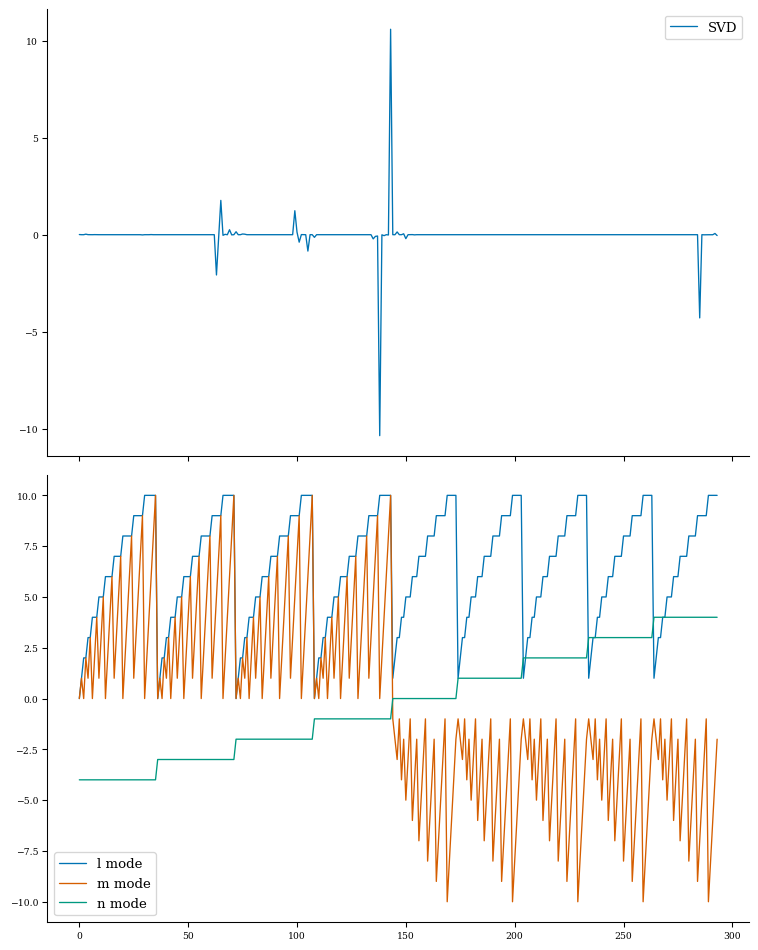

In [83]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
# axs[0].plot(diff_cho[start:end], label="SVD - Cholesky", lw=2)
axs[0].plot(step_svd[start:end], label="SVD", lw=1)
# axs[0].plot(step_qr[start:end], label="QR", lw=1)
# axs[0].plot(step_cho[start:end], label="CHO", lw=0.5)
axs[1].plot(eq.L_basis.modes[:, 0], label="l mode")
axs[1].plot(eq.L_basis.modes[:, 1], label="m mode")
axs[1].plot(eq.L_basis.modes[:, 2], label="n mode")
axs[0].legend()
axs[1].legend()
fig.savefig("difference-modes.png", dpi=400)

In [82]:
jnp.linalg.norm(J@step_svd-f), jnp.linalg.norm(J@step_cho-f), jnp.linalg.norm(J@step_qr-f)

(Array(0., dtype=float64),
 Array(0.0002, dtype=float64),
 Array(0., dtype=float64))

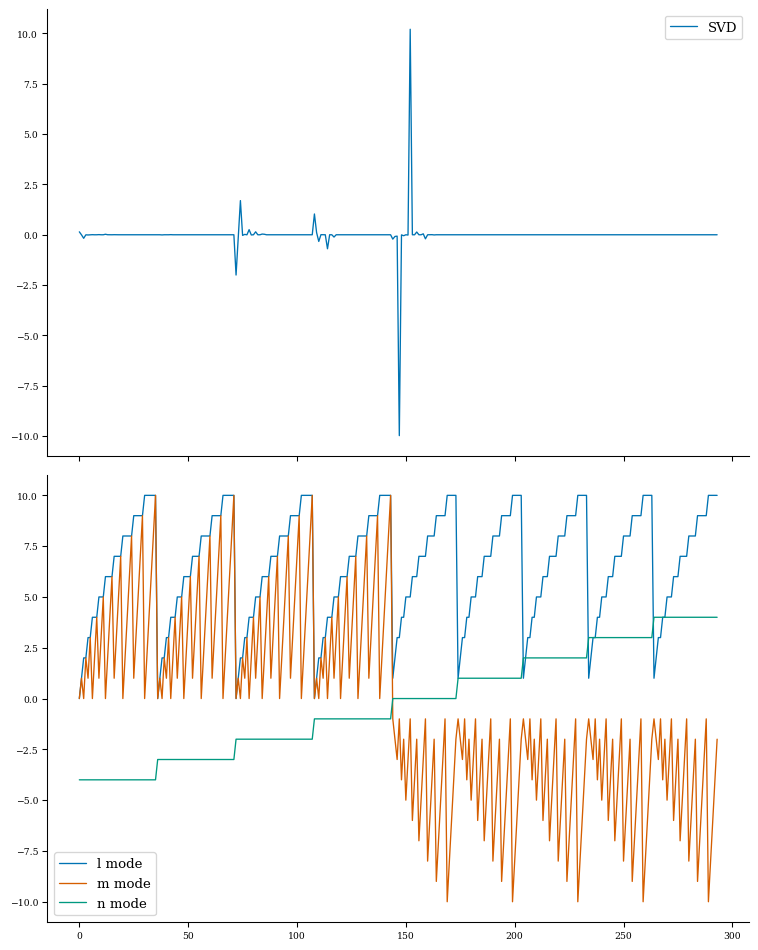

In [77]:
svd_full = obj._feasible_tangents@step_svd
cho_full = obj._feasible_tangents@step_cho
qr_full = obj._feasible_tangents@step_qr

fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
# axs[0].plot(diff_cho[start:end], label="SVD - Cholesky", lw=2)
axs[0].plot(svd_full[eq.x_idx["L_lmn"]], label="SVD", lw=1)
# axs[0].plot(qr_full[eq.x_idx["R_lmn"]], label="QR", lw=1)
# axs[0].plot(cho_full[eq.x_idx["L_lmn"]], label="CHO", lw=0.5)
axs[1].plot(eq.Z_basis.modes[:, 0], label="l mode")
axs[1].plot(eq.Z_basis.modes[:, 1], label="m mode")
axs[1].plot(eq.Z_basis.modes[:, 2], label="n mode")
axs[0].legend()
axs[1].legend()
fig.savefig("difference-modes-full-state.png", dpi=400)